In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [25]:
pip install -q git+https://github.com/tensorflow/examples.git

Note: you may need to restart the kernel to use updated packages.


In [26]:
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [2]:
%load_ext autoreload
%autoreload 2
from xrayproject.utils_DAM import load_pngs, spurious_funct, spurious_funct_2, \
get_img_sizes, get_img_heights, get_img_widths
from xrayproject.preprocessing import flip_resize, normalize
from xrayproject.utils import load_train, load_masks

from xrayproject import utils
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from PIL import Image
import pandas as pd
import numpy as np


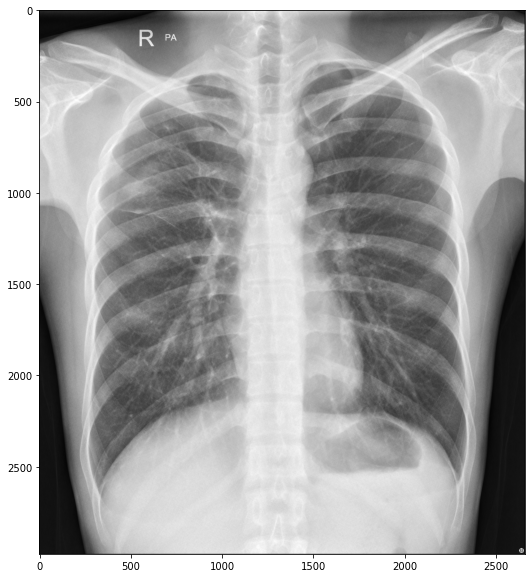

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [3]:
path = '../raw_data/raw_China/CXR_png'
img_PRC, target_PRC = load_pngs(10, get_all=False, get_random=True, balanced=True, path=path)
plt.subplots(figsize = (10,10))
plt.imshow(img_PRC[0])
plt.show()
print(target_PRC)

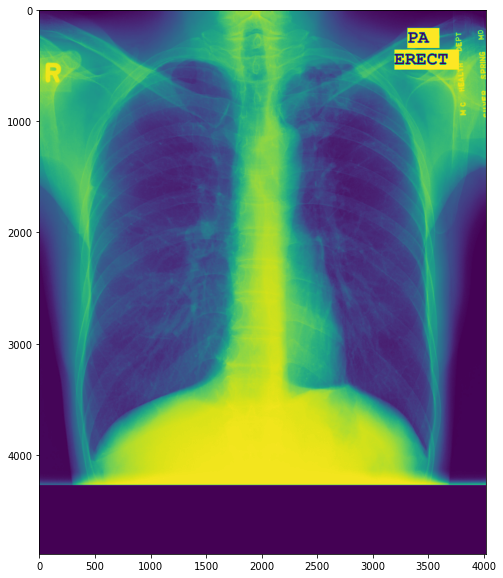

[(0, 4892, 4020), (1, 4020, 4892), (2, 4020, 4892), (3, 4020, 4892), (4, 4020, 4892), (5, 4892, 4020), (6, 4892, 4020), (7, 4892, 4020), (8, 4892, 4020), (9, 4892, 4020)]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [4]:
path = '../raw_data/raw_USA/CXR_png'
img_USA, target_USA = load_pngs(10, get_all=False, get_random=True, balanced=True, path=path)
plt.subplots(figsize = (10,10))
plt.imshow(img_USA[0])
plt.show()
print([(i, img_USA[i].shape[0], img_USA[i].shape[1]) for i in range(10) ])
print(target_USA)

In [5]:
print(img_USA[2].shape)
print(img_PRC[5].shape)

(4020, 4892, 1)
(2943, 3000, 3)


(4892, 4020, 1) (4020, 4892, 1)
(4892, 4020, 1) (4892, 4020, 1)


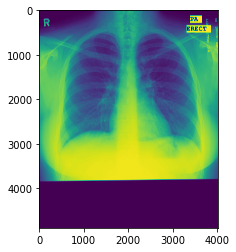

In [6]:
print(img_USA[0].shape, img_USA[1].shape)
print(img_USA[5].shape, img_USA[6].shape)
plt.imshow(img_USA[5])
plt.imshow(img_USA[6])
plt.show()

(4020, 4892, 1)


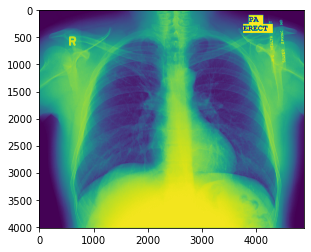

In [7]:
print(img_USA[1].shape)
plt.imshow(img_USA[1])
plt.show()

In [8]:
print(target_USA)
print(target_PRC)

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [9]:
def dim_imgs(examples):
    return [(example.shape[0], example.shape[1]) for example in examples]

In [10]:
print(dim_imgs(img_PRC))
print(dim_imgs(img_USA))

[(2977, 2658), (2945, 2450), (2900, 2624), (2944, 2720), (2989, 2729), (2943, 3000), (2843, 2622), (2978, 2990), (2710, 2549), (3001, 2679)]
[(4892, 4020), (4020, 4892), (4020, 4892), (4020, 4892), (4020, 4892), (4892, 4020), (4892, 4020), (4892, 4020), (4892, 4020), (4892, 4020)]


In [11]:
path = '../raw_data/raw_USA/CXR_png'
print(f"Image height-data: {get_img_heights(path)}")
print(f"Image width-data: {get_img_widths(path)}")
path = '../raw_data/raw_China/CXR_png'
print(f"Image height-data: {get_img_heights(path)}")
print(f"Image width-data: {get_img_widths(path)}")

Image height-data: (4892, 4020, 4279.072463768116, 398.4879507876184)
Image width-data: (4892, 4020, 4632.927536231884, 398.4879507876184)
Image height-data: (3001, 1130, 2699.084592145015, 333.65897270223803)
Image width-data: (3001, 948, 2794.0694864048337, 300.74557103123294)


In [12]:
def flip_resize(image, mask, input_shape=(224, 224)):
    input_image = tf.image.resize(image, input_shape)
    input_mask = tf.image.resize(mask, input_shape)

    input_image, input_mask = normalize(input_image, input_mask)

    input_image_flipped = tf.image.flip_left_right(input_image)
    input_mask_flipped = tf.image.flip_left_right(input_mask)

    return input_image, input_mask, input_image_flipped, input_mask_flipped

In [16]:
resized = [flip_resize(images[i], masks[i], input_shape=(224,224)) for i in range(len(images))]
print(resized[49][3].shape)

(224, 224, 1)


In [17]:
x1 = [n[0] for n in resized]
x2 = [n[2] for n in resized]

y1= [n[1] for n in resized]
y2 = [n[3] for n in resized]


In [18]:
image_dataset = x1 + x2
mask_dataset = y1 + y2 

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

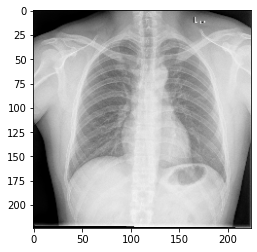

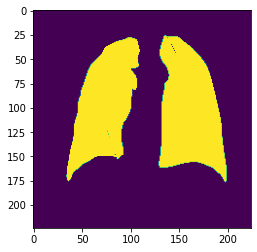

In [19]:
plt.imshow(image_dataset[1])
plt.show()
plt.imshow(mask_dataset[1])
plt.show()

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.2)

In [21]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(80, 224, 224, 3) (20, 224, 224, 3)
(80, 224, 224, 1) (20, 224, 224, 1)


# Code from Example on tensorflow website :

In [22]:
OUTPUT_CHANNELS = 1

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [27]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [28]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [29]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# testing model

In [30]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [31]:
TRAIN_LENGTH = len(X_test)
BATCH_SIZE = 5
BUFFER_SIZE = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [32]:
x_train = tf.image.rgb_to_grayscale(X_train)
x_val = tf.image.rgb_to_grayscale(X_val)
train_dataset = (x_train, y_train)
val_dataset = (x_val, y_val)

NameError: name 'X_val' is not defined

In [ ]:
def show_predictions(dataset=None , num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [33]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(X_train,y_train ,epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS,
                          validation_data=(X_test, y_test))

Epoch 1/5
4/4 [==============================] - 15s 3s/step - loss: 0.6798 - accuracy: 0.6964
Epoch 2/5
4/4 [==============================] - 10s 3s/step - loss: 0.4841 - accuracy: 0.7456
Epoch 3/5
4/4 [==============================] - 11s 3s/step - loss: 0.4061 - accuracy: 0.7503
Epoch 4/5
4/4 [==============================] - 13s 3s/step - loss: 0.3453 - accuracy: 0.7838
Epoch 5/5
4/4 [==============================] - 17s 4s/step - loss: 0.2981 - accuracy: 0.8301


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
plt.subplots(figsize = (10,10))
plt.imshow(resized[49][0])
plt.show()
plt.imshow(resized[49][1])

In [14]:
path_mask = '../raw_data/mask'
path = '../raw_data/raw_China/CXR_png'
masks, targets, ID = load_masks(50, get_all = False, get_random = False, balanced = True, path = path_mask)
#img_PRC, target_PRC = load_pngs(10, get_all=False, get_random=False, balanced=True, path=path)

Using path:  ../raw_data/mask


In [15]:
#targets
images, ID = load_train(path, ID )
print(images[4].shape)
print(masks[4].shape)

(2448, 2371, 3)
(2448, 2371, 1)


In [ ]:
plt.subplots(figsize = (10,10))
plt.imshow(masks[7])
plt.show()
plt.imshow(images[7])
plt.show()